# Using Non-linear Transformations

## Doing variable transformations

In [1]:
from sklearn.datasets import load_boston
from random import shuffle
boston = load_boston()
seed(0) # Creates a replicable shuffling
new_index = range(boston.data.shape[0])
shuffle(new_index) # shuffling the index
X, y = boston.data[new_index], boston.target[new_index]
print X.shape, y.shape, boston.feature_names

NameError: name 'seed' is not defined

In [14]:
print boston.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [15]:
import pandas as pd
df = pd.DataFrame(X,columns=boston.feature_names)
df['target'] = y

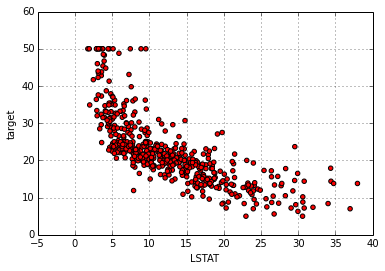

In [16]:
scatter = df.plot(kind='scatter', x='LSTAT', y='target', c='r')

In [17]:
import numpy as np
from sklearn.feature_selection.univariate_selection import f_regression
F, pval = f_regression(df['LSTAT'],y)
print 'F score for the original feature %.1f' % F
F, pval = f_regression(np.log(df['LSTAT']),y)
print 'F score for the transformed feature %.1f' % F

F score for the original feature 601.6
F score for the transformed feature 1000.2


## Creating interactions between variables

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
regression = LinearRegression(normalize=True)
crossvalidation = KFold(n=X.shape[0], n_folds=10, shuffle=True, random_state=1)

In [19]:
df = pd.DataFrame(X,columns=boston.feature_names)
baseline = np.mean(cross_val_score(regression, df, y, scoring='r2', cv=crossvalidation, n_jobs=1))
interactions = list()
for feature_A in boston.feature_names:
    for feature_B in boston.feature_names:
        if feature_A > feature_B:
            df['interaction'] = df[feature_A] * df[feature_B]
            score = np.mean(cross_val_score(regression, df, y, scoring='r2', cv=crossvalidation, n_jobs=1))
            if score > baseline:
                interactions.append((feature_A, feature_B, round(score,3)))
print 'Baseline R2: %.3f' % baseline
print 'Top 10 interactions: %s' % sorted(interactions, key=lambda(x):x[2], reverse=True)[:10]

Baseline R2: 0.720
Top 10 interactions: [('RM', 'LSTAT', 0.79), ('TAX', 'RM', 0.783), ('RM', 'RAD', 0.777), ('RM', 'PTRATIO', 0.768), ('RM', 'INDUS', 0.758), ('RM', 'NOX', 0.75), ('RM', 'AGE', 0.747), ('RM', 'B', 0.746), ('RM', 'DIS', 0.739), ('INDUS', 'DIS', 0.733)]


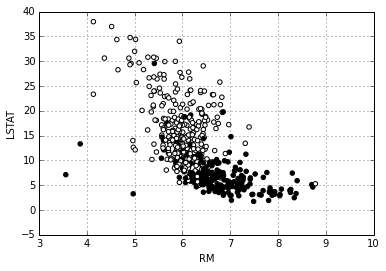

In [20]:
colors = ['k' if v > np.mean(y) else 'w' for v in y]
scatter = df.plot(kind='scatter', x='RM', y='LSTAT', c=colors)

In [21]:
# Adding polynomial features (x**2,y**2,xy)
polyX = pd.DataFrame(X,columns=boston.feature_names)
baseline = np.mean(cross_val_score(regression, polyX, y, scoring='mean_squared_error', cv=crossvalidation, n_jobs=1))
improvements = [baseline]
for feature_A in boston.feature_names: 
    polyX[feature_A+'^2'] = polyX[feature_A]**2
    improvements.append(np.mean(cross_val_score(regression, polyX, y, scoring='mean_squared_error', cv=crossvalidation, n_jobs=1)))
    for feature_B in boston.feature_names:
        if feature_A > feature_B:
            polyX[feature_A+'*'+feature_B] = polyX[feature_A] * polyX[feature_B]
            improvements.append(np.mean(cross_val_score(regression, polyX, y, scoring='mean_squared_error', cv=crossvalidation, n_jobs=1)))

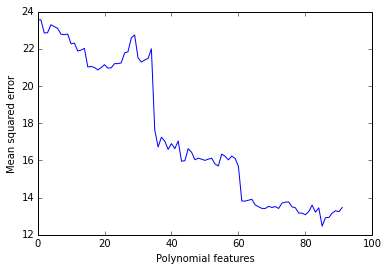

In [22]:
import matplotlib.pyplot as plt
plt.figure() 
plt.plot(range(0,92),np.abs(improvements),'-')
plt.xlabel('Polynomial features')
plt.ylabel('Mean squared error')
plt.show()

In [25]:
print shape(polyX)
crossvalidation = KFold(n=X.shape[0], n_folds=10, shuffle=True, random_state=1)
print 'Mean squared error %.3f' % abs(np.mean(cross_val_score(regression, polyX, y, scoring='mean_squared_error', cv=crossvalidation, n_jobs=1)))

(506, 104)
Mean squared error 13.466


# Regularizing linear models

## Relying on ridge regression

In [28]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge(normalize=True)
search = GridSearchCV(estimator=ridge, param_grid={'alpha':np.logspace(-5,2,8)}, 
                                       scoring='mean_squared_error', n_jobs=1, refit=True, cv=10)
search.fit(polyX,y)
print 'Best parameters: %s' % search.best_params_
print 'CV MSE of best parameters: %.3f' % abs(search.best_score_)

Best parameters: {'alpha': 0.001}
CV MSE of best parameters: 12.385


## Using the Lasso

In [29]:
from sklearn.linear_model import Lasso
lasso = Lasso(normalize=True)
search = GridSearchCV(estimator=lasso, param_grid={'alpha':np.logspace(-5,2,8)}, 
                                       scoring='mean_squared_error', n_jobs=1, refit=True, cv=10)
search.fit(polyX,y)
print 'Best parameters: %s' % search.best_params_
print 'CV MSE of best parameters: %.3f' % abs(search.best_score_)

Best parameters: {'alpha': 0.0001}
CV MSE of best parameters: 12.644


## Combining L1 & L2: Elasticnet

In [31]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(normalize=True)
search = GridSearchCV(estimator=elastic, param_grid={'alpha':np.logspace(-5,2,8), 'l1_ratio': [0.25, 0.5, 0.75]}, 
                                       scoring='mean_squared_error', n_jobs=1, refit=True, cv=10)
# For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty
search.fit(polyX,y)
print 'Best parameters: %s' % search.best_params_
print 'CV MSE of best parameters: %.3f' % abs(search.best_score_)

Best parameters: {'alpha': 1.0000000000000001e-05, 'l1_ratio': 0.5}
CV MSE of best parameters: 12.162


## Leveraging regularization for feature selection

In [32]:
lasso = Lasso(normalize=True, alpha=0.01)
lasso.fit(polyX,y)
print polyX.columns[np.abs(lasso.coef_)>0.0001].values

['CRIM*CHAS' 'ZN*CRIM' 'ZN*CHAS' 'INDUS*DIS' 'CHAS*B' 'NOX^2' 'NOX*DIS'
 'RM^2' 'RM*CRIM' 'RM*NOX' 'RM*PTRATIO' 'RM*B' 'RM*LSTAT' 'RAD*B' 'TAX*DIS'
 'PTRATIO*NOX' 'LSTAT^2']


# Fighting with Big Data: Stochastic Gradient Descent

## Determining when there is too much data

## Implementing classification and regression with SGD

In [34]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

SGD = SGDRegressor(loss='squared_loss', penalty='l2', alpha=0.0001, l1_ratio=0.15, n_iter=2000)
#  l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1
# alpha constant that multiplies the regularization term. Defaults to 0.0001
scaling = StandardScaler()
scaling.fit(polyX)
scaled_X = scaling.transform(polyX)
print 'CV MSE: %.3f' % abs(np.mean(cross_val_score(SGD, scaled_X, y, scoring='mean_squared_error', cv=crossvalidation, n_jobs=1)))

CV MSE: 12.802


In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.20, random_state=2)

SGD = SGDRegressor(loss='squared_loss', penalty='l2', alpha=0.0001, l1_ratio=0.15)
improvements = list()
for z in range(1000):
    SGD.partial_fit(X_train, y_train)
    improvements.append(mean_squared_error(y_test, SGD.predict(X_test)))

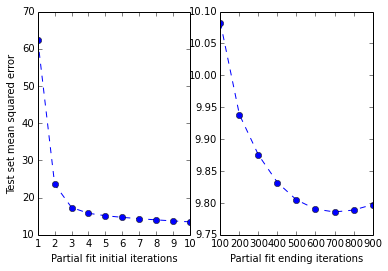

In [36]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1) 
plt.plot(range(1,11),np.abs(improvements[:10]),'o--')
plt.xlabel('Partial fit initial iterations')
plt.ylabel('Test set mean squared error')
plt.subplot(1,2,2) 
plt.plot(range(100,1000,100),np.abs(improvements[100:1000:100]),'o--')
plt.xlabel('Partial fit ending iterations')
plt.show()